<a href="https://colab.research.google.com/github/Aleksandr62aa/Decision_trees/blob/main/Cleaned_Dirty_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Solving the number classification problem on the Kaggle website**

#                          (Accuracy - 0,93951)

Used:

*   Transfer Learning
*   Model Resnet50
*   K-fold Cross-Validation
*   Neural network ensembles

In [1]:
# Connecting google drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


**Importing libraries**

In [2]:
import torch
import random
import shutil
import torchvision
import time
import os
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from torchvision import transforms, models

# Fixed seed

random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic = True

In [3]:
! ls


gdrive	sample_data


**Loading data**

In [4]:
# from google drive

data_root = '/content/gdrive/MyDrive/Cleaned_Dirty/plates'
test_dir_root = '/content/gdrive/MyDrive/Cleaned_Dirty/plates/test'
print(os.listdir(data_root))

['test', 'train', 'test1']


In [5]:
# from google Colab
dir_colab = '/content'


In [6]:
# Creating directories
train_dir = ['train1', 'train2','train3','train4','train5']
val_dir = ['val1', 'val2','val3','val4','val5']
class_names = ['cleaned', 'dirty']

for dir_tpain, dir_val in zip(train_dir, val_dir):
    for class_name in class_names:
        os.makedirs(os.path.join(dir_tpain, class_name), exist_ok=True)
        os.makedirs(os.path.join(dir_val, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        for j in range(5):
            if (j*4) <= i <= (3 + j*4):
              shutil.copy(os.path.join(source_dir, file_name),
                          os.path.join(val_dir[j], class_name, file_name))
            else:
              shutil.copy(os.path.join(source_dir, file_name),
                          os.path.join(train_dir[j], class_name, file_name))

100%|██████████| 20/20 [00:02<00:00,  6.82it/s]


**Preprocessing data**

In [7]:
train_dataloader = []
val_dataloader = []
batch_size = 8
k_fold = 5

train_transforms = [
                   transforms.Compose([
                    transforms.Resize((224)),
                    transforms.CenterCrop((224)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),

                    transforms.Compose([
                    transforms.Resize((224)),
                    transforms.CenterCrop((224)),
                    transforms.ColorJitter(hue=(-0.5,0.5)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),

                    transforms.Compose([
                    transforms.Resize((224)),
                    transforms.CenterCrop((224)),
                    transforms.ColorJitter(hue=(-0.5,0.5)),
                    transforms.RandomVerticalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),

                    transforms.Compose([
                    transforms.Resize((224)),
                    transforms.CenterCrop((224)),
                    # transforms.ColorJitter(hue=(-0.5,0.5)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

]

val_transforms = transforms.Compose([
    transforms.Resize((224)),
    transforms.CenterCrop((224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

for i in range(k_fold):

  # dataset train, val
  train_dataset  = torchvision.datasets.ImageFolder(train_dir[i], train_transforms[0])

  # train_dataset = torch.utils.data.ConcatDataset([torchvision.datasets.ImageFolder(train_dir[i],train_transform)
  #                                                   for train_transform in train_transforms])

  val_dataset = torchvision.datasets.ImageFolder(val_dir[i], val_transforms)

  # dataloader_batch train, val
  train_dataloader.append(torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                      shuffle=True, num_workers=batch_size))
  val_dataloader.append(torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                                      shuffle=True, num_workers=batch_size))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
print('train:', len(train_dataset), 'batch:', len(train_dataloader[0]))
print('val:', len(val_dataset), 'batch:', len(val_dataloader[0]))

train: 32 batch: 4
val: 8 batch: 1


**Data  test**

In [9]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

# dataset test
test_dataset = ImageFolderWithPaths(test_dir_root, val_transforms)

# dataloader test
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [10]:
print('test:', len(test_dataset), 'batch:', len(test_dataloader))


test: 744 batch: 93


**Visualization of images**

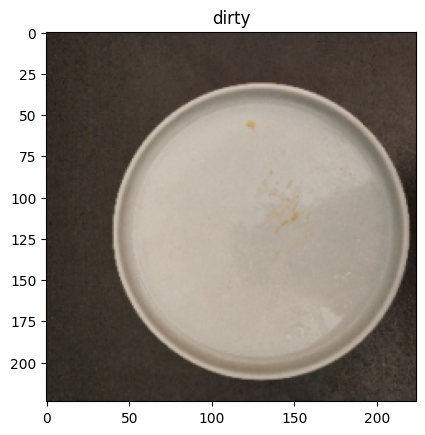

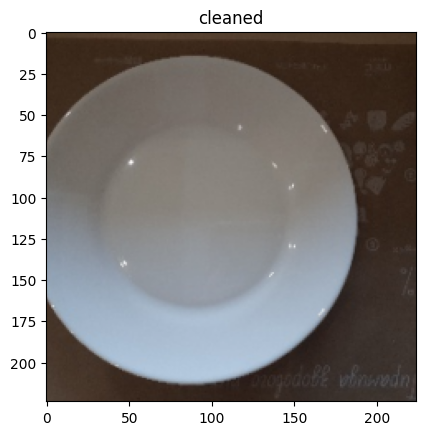

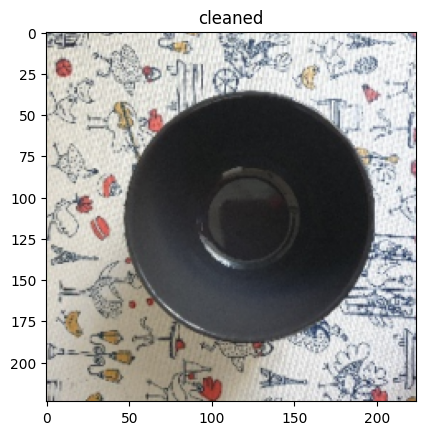

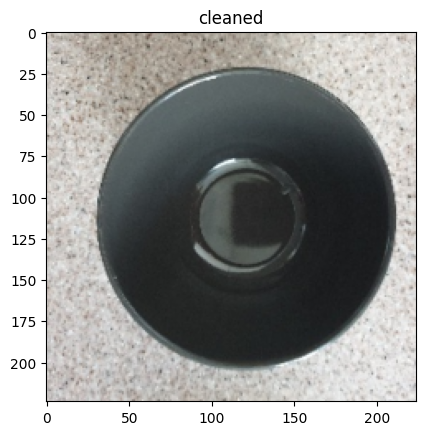

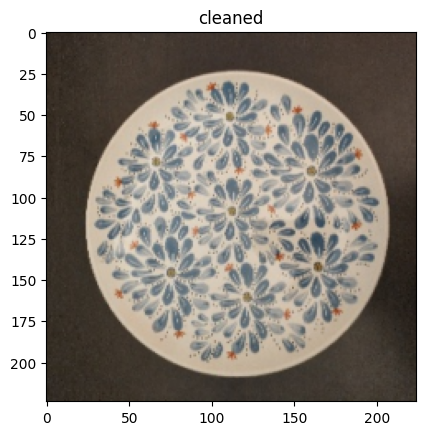

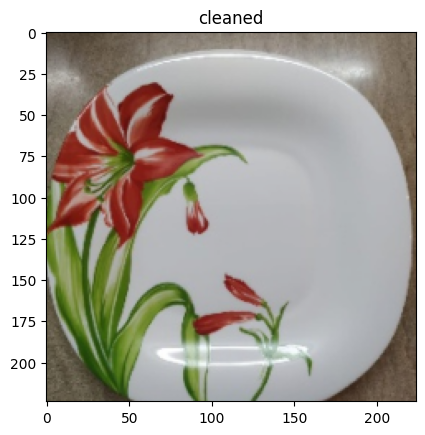

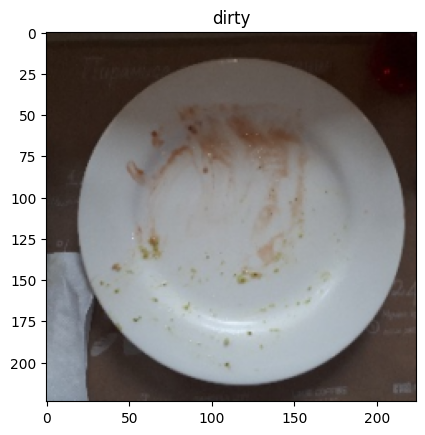

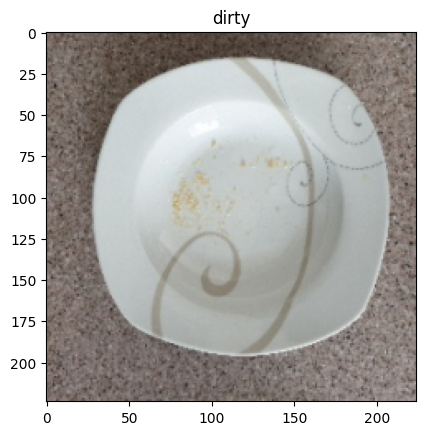

In [11]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader[0]))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])



**Train model**

In [12]:
# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [13]:
def train_model(model, loss, optimizer, scheduler, tr_dataloader, vl_dataloader, num_epochs=1):

    tr_loss_history = []
    tr_accuracy_history = []
    vl_loss_history = []
    vl_accuracy_history = []

    for epoch in range(num_epochs):
        # print(f'Epoch {epoch}/{num_epochs - 1}', flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = tr_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = vl_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase =='train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean().cpu()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if phase == 'train':
              tr_loss_history.append(epoch_loss)
              tr_accuracy_history.append(epoch_acc)
            elif phase == 'val':
              vl_loss_history.append(epoch_loss)
              vl_accuracy_history.append(epoch_acc)

            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return (model, tr_loss_history, tr_accuracy_history, vl_loss_history, vl_accuracy_history)

**Test model**


In [14]:
def test_model(model, test_dataloader):

  model.eval()   # Set model to evaluate mode
  running_acc = 0.
  dataloader = test_dataloader

  preds_class_list = []
  test_predictions = []

  for X_test, y_test, path_batch in tqdm(dataloader):
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    with torch.set_grad_enabled(False):
      preds = model(X_test)

    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu())
    preds_class = preds.argmax(dim=1)
    preds_class_list.append(preds_class)





    running_acc += (preds_class == y_test.data).float().mean().cpu()

  # test_predictions = np.concatenate(test_predictions)

  # statistics
  acc = running_acc / len(dataloader)
  print(f'Acc: {acc}')

  return test_predictions


**Create model**

In [15]:
def сreate_model():
  # model = models.resnet18(pretrained=True)
  model = models.resnet50(pretrained=True)

# Disable grad for all conv layers
  # for param in model.parameters():
  #     param.requires_grad = False

  for name, child in model.named_children():
    if name in ['layer3','layer4']:
      for param in child.parameters():
        param.requires_grad = True
    else:
      for param in child.parameters():
        param.requires_grad = False

  model.fc = torch.nn.Linear(model.fc.in_features, 2)
  model = model.to(device)

  optimizer = torch.optim.Adam(filter(lambda x: x.requires_grad, model.parameters()), amsgrad=True, lr=1.0e-3)
  # optimizer = torch.optim.SGD(filter(lambda x: x.requires_grad, model.parameters()), lr=1.0e-3, weight_decay = 0.1, momentum = 0.9)

  # Decay LR by a factor of 0.1 every 7 epochs
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

  return (model, optimizer, scheduler)


In [16]:
model = сreate_model()[0]
# for name, param in model.named_parameters():
#   if param.requires_grad:
#     print("\t",name, "- True")
#   else:
#     print("\t",name, "- False")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 143MB/s]


In [17]:
loss = torch.nn.CrossEntropyLoss()

**Result train model_0**

In [18]:
num_epochs=15
model, optimizer, scheduler = сreate_model()
model_test_0, tr_loss_his, tr_acc_his, vl_loss_his, vl_acc_his  = train_model(model, loss,
                                                 optimizer, scheduler, train_dataloader[0],
                                                 val_dataloader[0], num_epochs=num_epochs)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


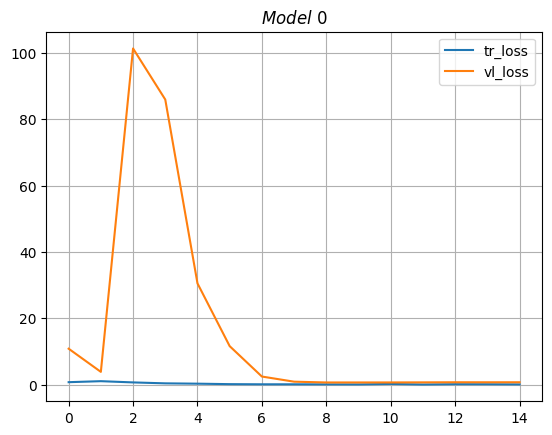

In [19]:
plt.plot(tr_loss_his, label='tr_loss')
plt.plot(vl_loss_his, label='vl_loss')
plt.legend()
plt.title('$Model$ $0$')
plt.grid(True)

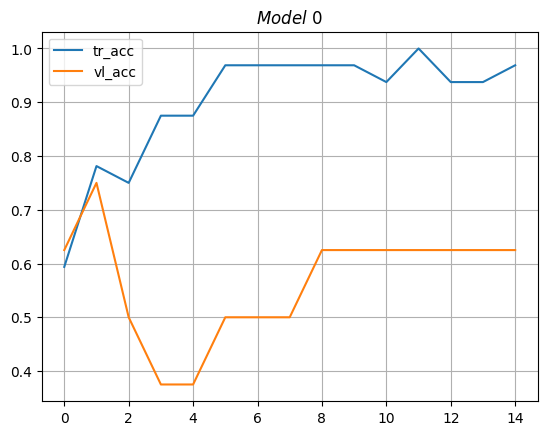

In [20]:
plt.plot(tr_acc_his, label='tr_acc')
plt.plot(vl_acc_his, label='vl_acc')
plt.legend()
plt.title('$Model$ $0$')
plt.grid(True)

**Result train model_1**

In [21]:
a

num_epochs=15
model, optimizer, scheduler = сreate_model()
model_test_1, tr_loss_his, tr_acc_his, vl_loss_his, vl_acc_his  = train_model(model, loss,
                                                 optimizer, scheduler, train_dataloader[1],
                                                 val_dataloader[1], num_epochs=num_epochs)

NameError: ignored

In [ ]:
plt.plot(tr_loss_his, label='tr_loss')
plt.plot(vl_loss_his, label='vl_loss')
plt.legend()
plt.title('$Model$ $1$')
plt.grid(True)

In [ ]:
plt.plot(tr_acc_his, label='tr_acc')
plt.plot(vl_acc_his, label='vl_acc')
plt.legend()
plt.title('$Model$ $1$')
plt.grid(True)

**Result train model_2**

In [ ]:
num_epochs=15
model, optimizer, scheduler = сreate_model()
model_test_2, tr_loss_his, tr_acc_his, vl_loss_his, vl_acc_his  = train_model(model, loss,
                                                 optimizer, scheduler, train_dataloader[2],
                                                 val_dataloader[2], num_epochs=num_epochs)

In [ ]:
plt.plot(tr_loss_his, label='tr_loss')
plt.plot(vl_loss_his, label='vl_loss')
plt.legend()
plt.title('$Model$ $2$')
plt.grid(True)

In [ ]:
plt.plot(tr_acc_his, label='tr_acc')
plt.plot(vl_acc_his, label='vl_acc')
plt.legend()
plt.title('$Model$ $2$')
plt.grid(True)

**Result train model_3**

In [ ]:
num_epochs=15
model, optimizer, scheduler = сreate_model()
model_test_3, tr_loss_his, tr_acc_his, vl_loss_his, vl_acc_his  = train_model(model, loss,
                                                 optimizer, scheduler, train_dataloader[3],
                                                 val_dataloader[3], num_epochs=num_epochs)

In [ ]:
plt.plot(tr_loss_his, label='tr_loss')
plt.plot(vl_loss_his, label='vl_loss')
plt.legend()
plt.title('$Model$ $3$')
plt.grid(True)

In [ ]:
plt.plot(tr_acc_his, label='tr_acc')
plt.plot(vl_acc_his, label='vl_acc')
plt.legend()
plt.title('$Model$ $3$')
plt.grid(True)

**Result train model_4**

In [ ]:
num_epochs=15
model, optimizer, scheduler = сreate_model()
model_test_4, tr_loss_his, tr_acc_his, vl_loss_his, vl_acc_his  = train_model(model, loss,
                                                 optimizer, scheduler, train_dataloader[4],
                                                 val_dataloader[4], num_epochs=num_epochs)

In [ ]:
plt.plot(tr_loss_his, label='tr_loss')
plt.plot(vl_loss_his, label='vl_loss')
plt.legend()
plt.title('$Model$ $4$')
plt.grid(True)

In [ ]:
plt.plot(tr_acc_his, label='tr_acc')
plt.plot(vl_acc_his, label='vl_acc')
plt.legend()
plt.title('$Model$ $4$')
plt.grid(True)

**Ensembles models**

In [ ]:
# Test model_0 - model_4
pr_cls_0 = test_model(model_test_0, test_dataloader)
pr_cls_1 = test_model(model_test_1, test_dataloader)
pr_cls_2 = test_model(model_test_2, test_dataloader)
pr_cls_3 = test_model(model_test_3, test_dataloader)
pr_cls_4 = test_model(model_test_4, test_dataloader);


In [ ]:
running_acc = 0
test_predictions = []
test_img_paths = []
for y_0, y_1, y_2, y_3, y_4, test_data in tqdm(zip(pr_cls_0, pr_cls_1, pr_cls_2,
                                              pr_cls_3, pr_cls_4, test_dataloader)):

    _ , y_test, path_batch = test_data
    y_test = y_test.to(device)

    preds = (y_0 + y_1 + y_2 + y_3 + y_4)/4

    for i, pred in enumerate(preds):
      if pred > 0.5:
        preds[i] = 1
      else:
        preds[i] = 0

    running_acc += (preds == y_test.data).float().mean().cpu()
    test_predictions.extend(preds)
    test_img_paths.extend(path_batch)

  # statistics
acc = running_acc / len(test_dataloader)
print(f'Acc: {acc}')

**Create output csv file**

In [ ]:
test_predictions = ['dirty' if pred == 1 else 'cleaned' for pred in test_predictions]
test_img_paths = [patch[-8:-4] for patch in test_img_paths]

submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
submission_df.set_index('id', inplace=True)
submission_df.to_csv('sample_submission.csv')
submission_df.head(n=30)

In [ ]:
# shutil.rmtree('/content/test')

In [ ]:
!rm -rf train val test


In [ ]:
test_predictions = [0.2, 0.3, 0.9]
test_predictions = [0 if pred > 0.5 else 1 for pred in test_predictions]
test_predictions


In [ ]:
5 // 3


In [ ]:
def build(L):
    create node t
    if the stopping criterion is True:
        assign a predictive model to t
    else:
        Find the best binary split L = L_left + L_right
        t.left = build(L_left)
        t.right = build(L_right)
    return t
